In [1]:
import numpy as np
import tensorflow as tf
import gym
import pandas as pd
import seaborn as sns
sns.set()

# Deep $Q$ networks (DQN)

In previous notebooks, we have seen how we can use `tensorflow` and autodifferentiation to do tabular $Q$-learning in the context of a regression problem. While this technique is powerful for environments with small (finite) observation spaces $\mathcal{S}$ and action spaces $\mathcal{O}$, we run into problems when our observation space is continuous (or even just large!).

Tabular $Q$-learning is only guaranteed to converge if all state-action pairs are visited infinitely many times. In practice, this generally just means a very large number to get a reasonable approximation of the $Q$-function. However, when the observation space becomes large (such as using image inputs), it is likely that we only encounter each state-action pair at most once. Thus, $Q$-learning is not guaranteed to converge.

Instead, we want a technique that can estimate $Q$-values such that similar states produce similar outputs. This would allow us to learn from some state-action pairs, and then generalize to other unseen state-action pairs. By using a **differentiable function approximator**, we get this kind of behaviour. Recall that $Q$-learning is a *regression* problem, meaning any kind of regression model could work - even a linear regression. However, the most popular model used by *deep* reinforcement learning researchers is the *deep* neural network.

If you are familiar with supervised learning in deep learning, you may be familiar with techniques like dropout, batch normalization, and activity regularization. So far, these kinds of techniques do not prove extremely useful in the context of reinforcement learning. Instead, fully-connected neural networks with a small number of hidden units consisting of rectified linear units tend to perform best. ([Pieter Abbeel](https://www.youtube.com/watch?v=l-mYLq6eZPY) notes that on simple problems, linear feedback control can perform well even in complex environments. Fully-connected neural networks that use ReLU activations function as multi-step piecewise linear feedback controllers, hence their success).

When using neural networks, rather than passing many state-action pairs to the network and predicting a scalar $Q(s_t, a_t)$, we pass only the state $s_t$ and produce a vectorized output $\vec{Q}(s_t)$ where each entry in the vector corresponds to the predicted $Q$-value for each action available to the agent. Note that this necessitates that $\mathcal{A}$ is finite (and generally small), a limitation of $DQN$ that we will overcome later in the section on policy gradients.

![image of deep-q-network mapping single state to multiple outputs](../images/q-network.png)

In this notebook, we make use of `tensorflow`'s `keras` API to build neural networks. We also take advantage of **batched environments** to accelerate data collection. The `keras` api build neural networks that process inputs in **batches**. This means that if our observation space for a single environment has a shape $84 \times 84 \times 3$, then the network expects inputs of shape $B \times 84 \times 84 \times 3$ where $B$ is the number of inputs in the batch.

When running the tabular $Q$-learning agent in `tensorflow` in the previous notebook, runtime was considerably slower than the simply numpy-based agent. The computation time spent evaluating and updating the policy dominated the time to perform a single step/update of the agent, compared to the time spent simulating a step in the environment. Ideally, the time spent should be 50% policy evaluation and 50% environment stepping. By using batched environments, we can even this out. Furthermore, this means that we get more data per wall-clock-time, which will accelerate learning. This will be different from most tutorials which use `keras`, where a single environment is used, and inputs are manipulated to trick keras into treating them like a batch.

In [2]:
class Network:
    def __init__(self, hidden_units):
        self.layers = [tf.keras.layers.Dense(units, 
                                    activation='relu', 
                                    kernel_initializer='he_uniform', 
                                    use_bias=False) for units in hidden_units[:-1]]
        self.layers.append(tf.keras.layers.Dense(hidden_units[-1],
                                                activation='linear',
                                                kernel_initializer='zeros',
                                                use_bias=False))
    
    def call(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [3]:
class Agent:
    def __init__(self, state_shape, num_actions, num_envs,
                 epsilon_i=1.0, 
                 epsilon_f=0.0, 
                 n_epsilon=0.1, 
                 alpha=0.5, 
                 gamma = 0.95,
                 hidden_units = []
                ):
        
        tf.reset_default_graph()
        
        self.epsilon_i = epsilon_i
        self.epsilon_f = epsilon_f
        self.epsilon = tf.get_variable("epsilon", initializer=tf.constant(self.epsilon_i))
        self.n_epsilon = n_epsilon
        self.state_shape = state_shape
        self.num_actions = num_actions
        self.num_envs = num_envs
        self.alpha = alpha
        self.gamma = gamma

        self.s_t_ph = tf.placeholder(shape=(None, *state_shape), dtype=tf.float32, name="state")
        self.a_t_ph = tf.placeholder(shape=(None, ), dtype=tf.int32, name="action")
        self.r_t_ph = tf.placeholder(shape=(None, ), dtype=tf.float32, name="reward")
        self.s_t_next_ph = tf.placeholder(shape=(None, *state_shape), dtype=tf.float32, name="next_state")
        self.d_t_ph = tf.placeholder(shape=(None, ), dtype=tf.float32, name="done")
        self.n_ph = tf.placeholder(shape=(), dtype=tf.float32, name="n")
        
        self.Q = Network(hidden_units+[self.num_actions])

        self.decay_epsilon = self.decay_epsilon_tf(self.n_ph)
        self.act = self.act_tf(self.s_t_ph)
        self.update = self.update_tf(self.s_t_ph, self.a_t_ph, self.r_t_ph, self.s_t_next_ph, self.d_t_ph)
        
    def decay_epsilon_tf(self, n):
        return tf.assign(self.epsilon, tf.maximum(
            self.epsilon_f, 
            self.epsilon_i - (n/self.n_epsilon)*(self.epsilon_i - self.epsilon_f)))
    
    def act_tf(self, s_t):
        return tf.where(tf.random_uniform(shape=(self.num_envs, ), minval=0, maxval=1, dtype=tf.float32) < self.epsilon,
                      tf.random_uniform(shape=(self.num_envs, ), minval=0, maxval=self.num_actions, dtype=tf.int32) ,
                      tf.argmax(self.Q.call(s_t), output_type=tf.int32, axis=1))
    
    def update_tf(self, s_t, a_t, r_t, s_t_next, d_t):
        Q_next = tf.reduce_max(self.Q.call(s_t_next), axis=1)
        TD = r_t + (1-d_t)*self.gamma*Q_next
        Q_pred = tf.reduce_sum(self.Q.call(s_t) * tf.one_hot(a_t, self.num_actions), axis=1)
        loss = tf.reduce_mean(0.5*(Q_pred - tf.stop_gradient(TD))**2)
        return tf.train.GradientDescentOptimizer(self.alpha).minimize(loss)

In [4]:
def train(env, agent, T=100000):
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    rewards = []
    episode_rewards = 0
    
    s_t = env.reset()
    
    for t in range(T):
        if t%1000 == 0:
            print(f'{100*t/T}%', end='\r')
        a_t = sess.run(agent.act, 
                       feed_dict={
                           agent.s_t_ph:s_t
                       }
                      )   

        s_t_next, r_t, d_t, info = env.step(a_t)
        sess.run([agent.update, agent.decay_epsilon], 
                 feed_dict={
                     agent.s_t_ph:s_t,
                     agent.a_t_ph:a_t,
                     agent.r_t_ph:r_t,
                     agent.s_t_next_ph:s_t_next,
                     agent.d_t_ph:d_t,
                     agent.n_ph:t/T,
                 }
                )
        s_t = s_t_next
        episode_rewards += r_t
        
        for env_index in range(env.num_envs):
            if d_t[env_index]:
                rewards.append(episode_rewards[env_index])
                episode_rewards[env_index] = 0
                s_t[env_index] = env.reset_at(env_index)
            
    sess.close()
    return rewards

In [5]:
def plot(data, window=100):
    sns.lineplot(
        data=data.rolling(window=window).mean()[window-1::window]
    )

In [6]:
class DiscreteToBoxWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        assert isinstance(env.observation_space, gym.spaces.Discrete), \
            "Should only be used to wrap Discrete envs."
        self.n = self.observation_space.n
        self.observation_space = gym.spaces.Box(0, 1, (self.n,))
    
    def observation(self, obs):
        new_obs = np.zeros(self.n)
        new_obs[obs] = 1
        return new_obs

In [7]:
class VectorizedEnvWrapper(gym.Wrapper):
    def __init__(self, make_env, num_envs=1):
        super().__init__(make_env())
        self.num_envs = num_envs
        self.envs = [make_env() for env_index in range(num_envs)]
    
    def reset(self):
        return np.asarray([env.reset() for env in self.envs])
    
    def reset_at(self, env_index):
        return self.envs[env_index].reset()
    
    def step(self, actions):
        next_states, rewards, dones, infos = [], [], [], []
        for env, action in zip(self.envs, actions):
            next_state, reward, done, info = env.step(action)
            next_states.append(next_state)
            rewards.append(reward)
            dones.append(done)
            infos.append(info)
        return np.asarray(next_states), np.asarray(rewards), \
            np.asarray(dones), np.asarray(infos)

By using a single environment with a one-hot encoding, our program actually replicates tabular $Q$-learning! The neural network consists of a single `Dense` layer with no bias and an all-zero initializer, and the matrix multiplication with a one-hot encoding of the state is essentially analogous to indexing the $Q$-table (though if you actually check the math, you will find that the $Q$-table and the weight matrix for the `Dense` layer are transposes of eachother).

We can actually improve performance slightly by increasing the number of environments, which allows us to decrease the training time.

In [8]:
num_envs = 10
make_env = lambda: DiscreteToBoxWrapper(gym.make("FrozenLake-v0"))
env = VectorizedEnvWrapper(make_env, num_envs=num_envs)
state_shape = env.observation_space.shape
num_actions = env.action_space.n
agent = Agent(state_shape, num_actions, num_envs, alpha=0.8, gamma=0.95, epsilon_i=1.0, epsilon_f=0.0)

rewards = train(env, agent, T=20000)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


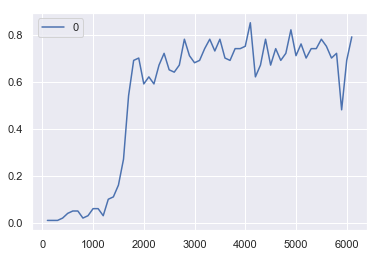

In [9]:
plot(pd.DataFrame(rewards))